# Fraud Detection in Online Payments:
<hr style="border:2px solid black">

## Goal: 
* Discover patterns of fraudulent activity in online payments
* Create a classification model to identify fraudulent transactions with high level of precision and recall
<hr style="border:2px solid black">

In [1]:
import pandas as pd
import numpy as np
import wrangle as wr
import matplotlib.pyplot as plt
import seaborn as sns
import explore as e
import model as m
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Filter out the UndefinedMetricWarning for precision
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
sns.set_context("notebook", rc={"axes.formatter.limits": (-2, 3)})

<hr style="border:2px solid black">

# **Wrangle**
Plan --> **Wrangle** --> Explore --> Model --> Deliver 

**Wrangle Actions:**
* Acquire Data from CSV
* Rename Columns
* Create new Variables
* Scale 'step'
* Add Baseline prediction
* Train, Validate, Test Split

In [2]:
# Acquire Data
df = wr.get_fraud_data()

# Prep Data
df = wr.prep_fraud(df)

# Split Function
train, validate, test = wr.split_function(df, 'isfraud')

<hr style="border:2px solid black">

# **Explore**
Plan --> Wrangle --> **Explore** --> Model --> Deliver

> ### <u>Q1: Is there a transaction type/types where fraud occurs significantly more often?</u>

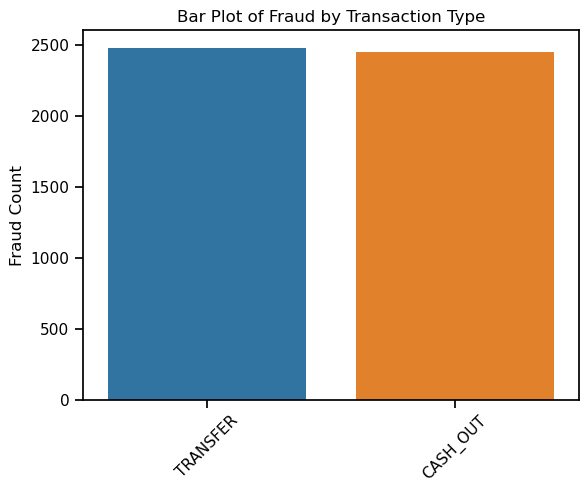

In [3]:
e.fraud_by_type(train)

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a Chi-Square Test to investigate whether fraud is independent of transaction type.**

* I will use a confidence interval of 99.9% 
* The resulting alpha is .001<br>

**H0: Fraud is independent of transaction type.**<br>
**Ha: Fraud is dependent on transaction type.**
</div>

In [4]:
alpha = 0.001
observed = pd.crosstab(train.isfraud, train.type)
chi2, p, degf, expected = stats.chi2_contingency(observed)

# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


Observed Values

[[ 839712 1339774   24774 1291267  317117]
 [      0    2449       0       0    2479]]
---
Expected Values

[[ 838628 1340490   24742 1289600  319183]
 [   1083    1732      31    1666     412]]
---

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
chi^2 = 13446.8505
p     = 0.0000
We reject the null hypothesis


> Takeaways: Fraud occurred exclusively in the TRANSFER and CASH_OUT transaction types. 

> ### <u>Q2: Does fraud occur significantly more often when the transaction amount is equal to the original account balance (complete withdrawl)?</u>

In [5]:
train[train.amount == train.oldbalanceorg][['type', 'amount', 'oldbalanceorg', 'newbalanceorig', 'isfraud']].head(10)

,type,amount,oldbalanceorg,newbalanceorig,isfraud
4012372,TRANSFER,677503.25,677503.25,0.00,1
5511891,TRANSFER,330218.85,330218.85,0.00,1
6044573,CASH_OUT,1265033.25,1265033.25,0.00,1
6360704,TRANSFER,455386.57,455386.57,0.00,1
6301479,TRANSFER,368951.94,368951.94,0.00,1
5561598,TRANSFER,136903.90,136903.90,0.00,1
4388539,TRANSFER,271150.29,271150.29,0.00,1
1030270,CASH_OUT,1398946.33,1398946.33,0.00,1
1511347,CASH_OUT,172510.95,172510.95,0.00,1
1059595,CASH_OUT,219489.62,219489.62,0.00,1


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a Chi-Square Test to investigate whether fraud is independent of complete withdrawals).**

* I will use a confidence interval of 99.9% 
* The resulting alpha is .001<br>

**H0: Fraud is independent of complete withdrawals.**<br>
**Ha: Fraud is dependent on complete withdrawals.**
</div>

In [6]:
alpha = 0.001
observed = pd.crosstab(train.isfraud, train.complete_withdrawal)

chi2, p, degf, expected = stats.chi2_contingency(observed)

# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


Observed Values

[[3812644       0]
 [    103    4825]]
---
Expected Values

[[3807825    4818]
 [   4921       6]]
---

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
chi^2 = 3736904.4422
p     = 0.0000
We reject the null hypothesis


> Takeaways: Transactions in this group were exclusively fraudulent. There were 4825 fraudulent observations in this group. This makes up 97.9% of fraudulent transactions in the training set.

> ### <u>Q3: Does fraud occur significantly more often when transaction type is transfer and amount is 10,000,000?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a Chi-Square Test to investigate whether fraud is independent 10M transfer.**

* I will use a confidence interval of 99.9% 
* The resulting alpha is .001<br>

**H0: Fraud is independent of 10M transfer.**<br>
**Ha: Fraud is dependent on 10M transfer.**
</div>

In [7]:
alpha = 0.001
observed = pd.crosstab(train.isfraud, train['10M_transfer'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)


# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


Observed Values

[[3810916    1728]
 [   4845      83]]
---
Expected Values

[[3810835    1808]
 [   4925       2]]
---

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
chi^2 = 2753.6245
p     = 0.0000
We reject the null hypothesis


> Takeaways: Fraud occurred 1.68% of the time in this group. While this seems low, this is much higher than the training set fraud rate of 0.13%.

> ### <u>Q4: Does fraud occur significantly more often when transaction type is 'TRANSFER' and destination balances are 0?</u>

In [8]:
train_fraud_only = train[train.isfraud == 1]
train_fraud_only[(train_fraud_only['type'] == 'TRANSFER') & (train_fraud_only['oldbalancedest'] == 0) & (train_fraud_only['newbalancedest'] == 0)][['type', 'amount','oldbalancedest', 'newbalancedest', 'isfraud']].sample(10)

,type,amount,oldbalancedest,newbalancedest,isfraud
1456142,TRANSFER,2873536.01,0.00,0.00,1
6361197,TRANSFER,116798.38,0.00,0.00,1
6281470,TRANSFER,10000000.00,0.00,0.00,1
6269553,TRANSFER,293470.64,0.00,0.00,1
2783639,TRANSFER,1368391.50,0.00,0.00,1
1511382,TRANSFER,1633227.00,0.00,0.00,1
3498775,TRANSFER,1950373.54,0.00,0.00,1
1932179,TRANSFER,211721.90,0.00,0.00,1
1030291,TRANSFER,3640271.29,0.00,0.00,1
6019700,TRANSFER,4017972.88,0.00,0.00,1


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a Chi-Square Test to investigate whether fraud is independent of transfer_missing_dest_balance.**

* I will use a confidence interval of 99.9% 
* The resulting alpha is .001<br>

**H0: Fraud is independent of transfer_missing_dest_balance.**<br>
**Ha: Fraud is dependent on transfer_missing_dest_balance.**
</div>

In [9]:
alpha = 0.001
observed = pd.crosstab(train.isfraud, train['transfer_missing_dest_balance'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


Observed Values

[[3812581      63]
 [   2466    2462]]
---
Expected Values

[[3810122    2521]
 [   4924       3]]
---

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
chi^2 = 1857600.1412
p     = 0.0000
We reject the null hypothesis


> Takeaways: 2462 of 2525 transactions in this group were fraudulent. A rate of 97.5%. This makes up 50% of fraudlent transactions in the training set. (There is some overlap between this group and the group where transaction amount is equal to original account balance.)

## Exploration Summary

> **Features Not Moving Forward:**
> 1. step
> 2. type 
> 3. amount
> 4. oldbalanceorg 
> 5. newbalanceorig
> 6. oldbalancedest
> 7. newbalancedest
> 8. 10M_transfer (less predictive than other features, and positive classes are contained within complete_withdrawal)

> **Features Moving Forward:** (Derived from type, amount, oldbalanceorg, newbalanceorig, oldbalancedest, newbalancedest)
> 1. transfer_cashout 
> 2. complete_withdrawal 
> 3. transfer_missing_dest_balance 
> 4. cashout_missing_orig_balance
> 5. step_scaled

<hr style="border:2px solid black">

# **Modeling**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver


In [10]:
# Feature Space
features_1 = ['complete_withdrawal',
 'transfer_missing_dest_balance',
 'cashout_missing_orig_balance',
 'transfer_cashout']

features_2 = ['complete_withdrawal',
 'transfer_missing_dest_balance',
 'cashout_missing_orig_balance',
 'transfer_cashout',
 'step_scaled']

# x/y split
X_train = train[features_1]
X_train_2 = train[features_2]

X_validate = validate[features_1]
X_validate_2 = validate[features_2]

X_test = test[features_1]
X_test_2 = test[features_2]

y_train = train.isfraud
y_validate = validate.isfraud
y_test = test.isfraud

## Baseline

In [11]:
m.get_baseline(train)

Baseline Accuracy: 0.9987
Baseline Precision Score: 0.0000
Baseline ROC AUC Score: 0.5


## Decision Tree

In [12]:
# Create Decision Tree Object
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit to train
clf = clf.fit(X_train, y_train)

# Predict Train and Validate
y_pred = clf.predict(X_train)
y_pred_val = clf.predict(X_validate)

# Add predictions to dataframe
train['DT_prediction'] = y_pred
validate['DT_prediction'] = y_pred_val

In [13]:
print('TRAIN')
print('Accuracy of Decision Tree classifier on training set: {:f}'
      .format(clf.score(X_train, y_train)))

print('Precision_Score of Decision Tree classifier on training set: {:f}'
      .format(precision_score(train.isfraud, y_pred)))

# roc_auc_score
y_true = train['isfraud']
y_true_val = validate['isfraud']

y_pred_class = train['DT_prediction']
y_pred_class_val = validate['DT_prediction']

# Convert predicted class labels to "soft" labels (probabilities)
y_pred_probabilities = np.where(y_pred_class == 1, 1, 0)
y_pred_probabilities_val = np.where(y_pred_class_val == 1, 1, 0)
roc_auc = roc_auc_score(y_true, y_pred_probabilities)
print("ROC AUC Score Training set:", roc_auc)



print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')

print('VALIDATE')
print('Accuracy of Decision Tree classifier on validate set: {:f}'
      .format(clf.score(X_validate, y_validate)))


print('Precision_Score of Decision Tree classifier on validate set: {:f}'
      .format(precision_score(validate.isfraud, y_pred_val)))


roc_auc = roc_auc_score(y_true_val, y_pred_probabilities_val)
print("ROC AUC Score Validate set:", roc_auc)

TRAIN
Accuracy of Decision Tree classifier on training set: 0.999979
Precision_Score of Decision Tree classifier on training set: 0.987329
ROC AUC Score Training set: 0.9980639782767176
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
VALIDATE
Accuracy of Decision Tree classifier on validate set: 0.999977
Precision_Score of Decision Tree classifier on validate set: 0.987311
ROC AUC Score Validate set: 0.9975556844281321


> Takeaways: DT model had perfect precision. There were no false positives. 

## Logistic Regression

### LR Model 1

In [14]:
# Create Regression object
logit = LogisticRegression(C=1, class_weight='balanced', random_state=666, intercept_scaling=1, solver='saga')

# Fit to train
logit.fit(X_train, y_train)

# predict train and validate
y_pred = logit.predict(X_train)
y_pred_val = logit.predict(X_validate)
y_pred_test = logit.predict(X_test)

# predict probability on train and validate
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba_val = logit.predict_proba(X_validate)
y_pred_proba_test = logit.predict_proba(X_test)

# add probability predictions to dataframes
train['LR_prediction'] = y_pred
validate['LR_prediction'] = y_pred_val
test['LR_prediction'] = y_pred_test

In [15]:
print('TRAIN')
print('Accuracy of Logistic Regression on training set: {:f}'
      .format(logit.score(X_train, y_train)))


print('Precision_Score of Logistic Regression on training set: {:f}'
      .format(precision_score(train.isfraud, y_pred)))

# roc_auc_score
y_true = train['isfraud']
y_true_val = validate['isfraud']
y_true_test = test['isfraud']

y_pred_class = train['LR_prediction']
y_pred_class_val = validate['LR_prediction']
y_pred_class_test = test['LR_prediction']


# Convert predicted class labels to "soft" labels (probabilities)
y_pred_probabilities = np.where(y_pred_class == 1, 1, 0)
y_pred_probabilities_val = np.where(y_pred_class_val == 1, 1, 0)
y_pred_probabilities_test = np.where(y_pred_class_test == 1, 1, 0)

roc_auc_class = roc_auc_score(y_true, y_pred_probabilities)
roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

print('ROC AUC Class Predictions Score on Training set:', roc_auc_class)
print("ROC AUC Probability Predictions Score Training set:", roc_auc)

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('VALIDATE')

print('Accuracy of Logistic Regression on validate set: {:f}'
      .format(logit.score(X_validate, y_validate)))


print('Precision_Score of Logistic Regression on validate set: {:f}'
      .format(precision_score(validate.isfraud, y_pred_val)))

roc_auc_class = roc_auc_score(y_true_val, y_pred_probabilities_val)
roc_auc = roc_auc_score(y_true_val, y_pred_proba_val[:, 1])

print('ROC AUC Class Predictions Score on Validate:', roc_auc_class)
print("ROC AUC Probability Predictions Score Validate set:", roc_auc)

TRAIN
Accuracy of Logistic Regression on training set: 0.999979
Precision_Score of Logistic Regression on training set: 0.987329
ROC AUC Class Predictions Score on Training set: 0.9980639782767176
ROC AUC Probability Predictions Score Training set: 0.9994680600905675
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
VALIDATE
Accuracy of Logistic Regression on validate set: 0.999977
Precision_Score of Logistic Regression on validate set: 0.987311
ROC AUC Class Predictions Score on Validate: 0.9975556844281321
ROC AUC Probability Predictions Score Validate set: 0.9992103719652736


### LR Model 2

In [16]:
# Create Regression object
logit = LogisticRegression(C=1, class_weight='balanced', random_state=666, intercept_scaling=1, solver='saga')

# Fit to train
logit.fit(X_train_2, y_train)

# predict train and validate
y_pred = logit.predict(X_train_2)
y_pred_val = logit.predict(X_validate_2)
y_pred_test = logit.predict(X_test_2)

# predict probability on train and validate
y_pred_proba = logit.predict_proba(X_train_2)
y_pred_proba_val = logit.predict_proba(X_validate_2)
y_pred_proba_test = logit.predict_proba(X_test_2)

# add probability predictions to dataframes
train['LR_prediction_2'] = y_pred
validate['LR_prediction_2'] = y_pred_val
test['LR_prediction_2'] = y_pred_test

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
print('TRAIN')
print('Accuracy of Logistic Regression on training set: {:f}'
      .format(logit.score(X_train_2, y_train)))


print('Precision_Score of Logistic Regression on training set: {:f}'
      .format(precision_score(train.isfraud, y_pred)))

# roc_auc_score
y_true = train['isfraud']
y_true_val = validate['isfraud']
y_true_test = test['isfraud']

y_pred_class = train['LR_prediction_2']
y_pred_class_val = validate['LR_prediction_2']
y_pred_class_test = test['LR_prediction_2']


# Convert predicted class labels to "soft" labels (probabilities)
y_pred_probabilities = np.where(y_pred_class == 1, 1, 0)
y_pred_probabilities_val = np.where(y_pred_class_val == 1, 1, 0)
y_pred_probabilities_test = np.where(y_pred_class_test == 1, 1, 0)

roc_auc_class = roc_auc_score(y_true, y_pred_probabilities)
roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

print('ROC AUC Class Predictions Score on Training set:', roc_auc_class)
print("ROC AUC Probability Predictions Score Training set:", roc_auc)

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('VALIDATE')

print('Accuracy of Logistic Regression on validate set: {:f}'
      .format(logit.score(X_validate_2, y_validate)))


print('Precision_Score of Logistic Regression on validate set: {:f}'
      .format(precision_score(validate.isfraud, y_pred_val)))

roc_auc_class = roc_auc_score(y_true_val, y_pred_probabilities_val)
roc_auc = roc_auc_score(y_true_val, y_pred_proba_val[:, 1])

print('ROC AUC Class Predictions Score on Validate:', roc_auc_class)
print("ROC AUC Probability Predictions Score Validate set:", roc_auc)

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('TEST')

print('Accuracy of Logistic Regression on test set: {:f}'
      .format(logit.score(X_test_2, y_test)))


print('Precision_Score of Logistic Regression on test set: {:f}'
      .format(precision_score(test.isfraud, y_pred_test)))

roc_auc_class = roc_auc_score(y_true_test, y_pred_probabilities_test)
roc_auc = roc_auc_score(y_true_test, y_pred_proba_test[:, 1])

print('ROC AUC Class Predictions Score on Test:', roc_auc_class)
print("ROC AUC Probability Predictions Score Test set:", roc_auc)

TRAIN
Accuracy of Logistic Regression on training set: 0.999979
Precision_Score of Logistic Regression on training set: 0.987329
ROC AUC Class Predictions Score on Training set: 0.9980639782767176
ROC AUC Probability Predictions Score Training set: 0.9998751011088062
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
VALIDATE
Accuracy of Logistic Regression on validate set: 0.999977
Precision_Score of Logistic Regression on validate set: 0.987311
ROC AUC Class Predictions Score on Validate: 0.9975556844281321
ROC AUC Probability Predictions Score Validate set: 0.9996657964688055
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TEST
Accuracy of Logistic Regression on test set: 0.999980
Precision_Score of Logistic Regression on test set: 0.986755
ROC AUC Class Predictions Score on Test: 0.9987740591335051
ROC AUC Probability Predictions Score Test set: 0.999942053558877


<hr style="border:2px solid black">

# **Conclusions**


## Summary

Fraudulent activity is not random. Fraudsters consistently use the same few tactics to avoid detection and maximize gains. 

* The most common fraud tactic was to completely wipe the original account balance.
* Next most common case of fraud was found in transfers with missing destination account balance. Possibly the transaction was manipulated to send to a fraudulent account instead of its intended destination.


## Recommendations

* Implement security protocols to prevent complete withdrawals of an account without identification.
* Investigate IT vulnerabilities that could allow hackers to change transfer destination

## Next Steps

* For high value transactions where the predicted probability of fraud was high, but not high enough to classify as fraudulent, pass to a human for further investigation.